In [ ]:
# Execute if necessary
# %%capture
# !pip install pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import plotly.express as px
from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as Dataset  
from torch.utils.data import Dataset
from torch.utils.data import DataLoader  
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

#from pytorchtools import EarlyStopping


/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Práctica 7: Redes Neuronales (Autoencoders Variacionales)

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

__Para esta práctica se deben usar bibliotecas__. Se recomienda el uso de:

- scikit-learn (https://scikit-learn.org/stable/)
- plotly express (https://plotly.com/python/plotly-express/)
- torch (https://pytorch.org/).

## Asignación 1

Seleccione algun dataset de su preferencia para el cual sea viable entrenar un modelo generativo (VAE), preferentemente de imagenes (pequeñas). Particione sus datos para poder realizar selección de modelos (__conjunto de validación__).

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a validation set of 10,000. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Labels

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

Each row is a separate image
Column 1 is the class label.
Remaining columns are pixel numbers (784 total).
Each value is the darkness of the pixel (1 to 255)

## Asignación 2

Realice un análisis exploratorio de datos y el preprocesamiento necesario para el dataset seleccionado.

In [2]:
df = pd.read_csv('./fashionmnist.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(df.isnull().sum())

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [8]:
print(df.describe())

              label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.247967      0.411467      0.805767      2.198283      5.682000   
std        4.306912      5.836188      8.215169    

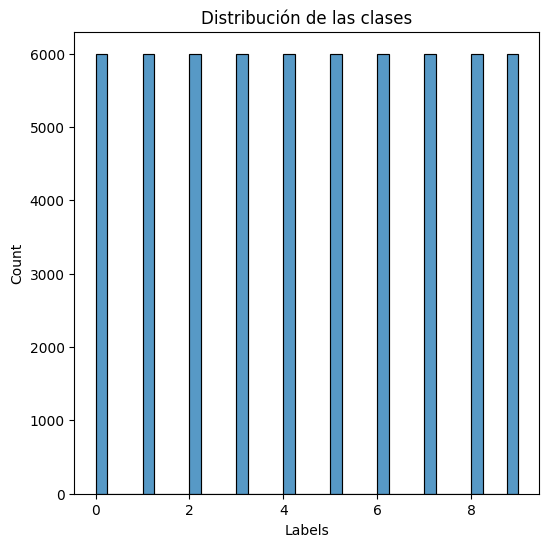

In [9]:
plt.figure(figsize=(6,6))
sns.histplot(df.label)
plt.title('Distribución de las clases')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## Asignación 3

Ajuste un Autoencoder Variacional (VAE) que permita realizar la generación de nuevos datos. Debe generar las curvas de entrenamiento (y graficarlas) e implementar el método de early stopping para seleccionar el modelo más adecuado.

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Two outputs for mean and variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        latent_params = self.encoder(x)
        mu = latent_params[:, :latent_dim]
        log_var = latent_params[:, latent_dim:]
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_var


In [11]:
def vae_loss(reconstructed, x, mu, log_var):
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss, kl_divergence, reconstruction_loss + kl_divergence


KL(q(z|X) || p(z)) = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

In [12]:
def train_vae(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed, mu, log_var = model(data)
        reconstruction_loss, kl_divergence, total_loss = vae_loss(reconstructed, data, mu, log_var)

        total_loss.backward()
        optimizer.step()
        train_loss += total_loss.item()

        print(f"Batch {batch_idx + 1}/{len(train_loader)}")
        print(f"Reconstruction Loss: {reconstruction_loss.item()}")
        print(f"KL Divergence Loss: {kl_divergence_loss.item()}")
        print(f"Total Loss: {total_loss.item()}")

    return train_loss / len(train_loader.dataset)


def validate_vae(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            reconstructed, mu, log_var = model(data)
            reconstruction_loss, kl_divergence, total_loss = vae_loss(reconstructed, data, mu, log_var)

            val_loss += total_loss.item()

            print(f"Batch {batch_idx + 1}/{len(val_loader)}")
            print(f"Validation Reconstruction Loss: {reconstruction_loss.item()}")
            print(f"Validation KL Divergence Loss: {kl_divergence_loss.item()}")
            print(f"Validation Total Loss: {total_loss.item()}")

    return val_loss / len(val_loader.dataset)


In [13]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.early_stop_epoch = None 

    def __call__(self, val_loss, epoch):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                self.early_stop_epoch = epoch  #Update epoch when early stopping
        else:
            self.best_score = val_loss
            self.counter = 0
        return self.early_stop, self.early_stop_epoch

In [14]:
def plot_early_stopping(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [15]:
class CustomFashionMNIST(Dataset):
    def __init__(self, root, train=True):
        self.dataset = FashionMNIST(root=root, train=train, transform=ToTensor(), download=True)
    
    def __getitem__(self, index):
        image, target = self.dataset[index]
        return image.view(-1), target

    def __len__(self):
        return len(self.dataset)

In [16]:
batch_size = 64

train_dataset = CustomFashionMNIST(root='./data', train=True)
val_dataset = CustomFashionMNIST(root='./data', train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 20 
model = VAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 100
train_losses = []
val_losses = []
early_stopping = EarlyStopping(patience=3, delta=0)
checkpoint_path = 'vae_checkpoint.pth'
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_vae(model, train_loader, optimizer, device)
    val_loss = validate_vae(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'latent_dim': latent_dim,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'epoch': epoch
        }
        torch.save(checkpoint, checkpoint_path)

    stop_early, stop_epoch = early_stopping(val_loss, epoch)
    if stop_early:
        print("Early stopping at epoch:", stop_epoch)
        break

plot_early_stopping(train_losses, val_losses)

![Picture title](image-20230606-232311.png)

In [22]:
# Save the model
model_path = './vae_model.pth'
torch.save(model.state_dict(), model_path)

## Asignación 4

Realice la generación de nuevos datos utilizando su modelo. Debe generar evidencia sobre el correcto funcionamiento de su modelo.

In [17]:
checkpoint_path = 'vae_checkpoint.pth'
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
latent_dim = checkpoint['latent_dim']
model = VAE(latent_dim)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [18]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

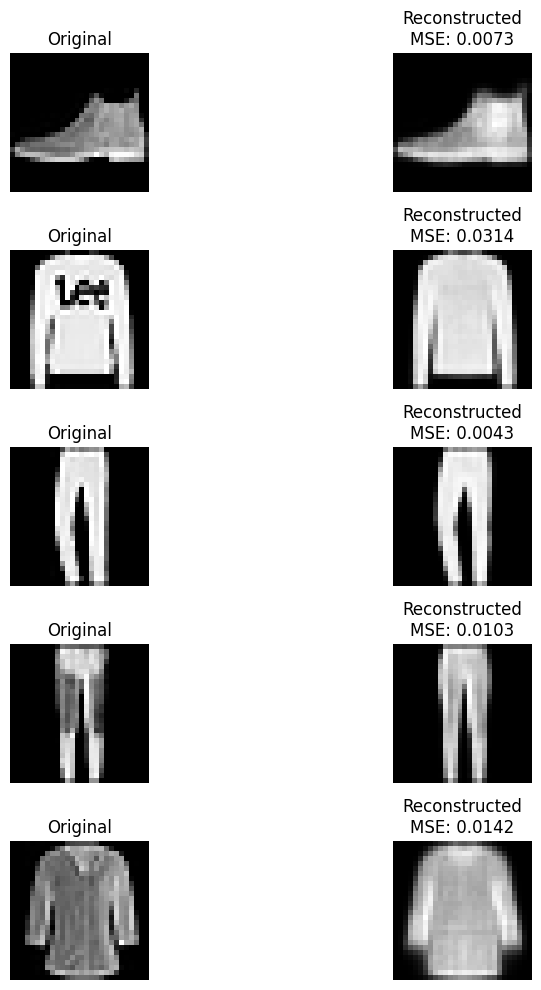

In [20]:

def compute_mse(reconstructed, original):
    mse = torch.mean((reconstructed - original) ** 2)
    return mse.item()

model = model.to("cpu")

num_images = 5
fig, axes = plt.subplots(num_images, 2, figsize=(10, 2*num_images))
for i in range(num_images):
   
    original, _ = val_dataset[i]
    original = original.to("cpu")

    with torch.no_grad():
        reconstructed, _, _ = model(original.unsqueeze(0))
    reconstructed = reconstructed.squeeze().cpu()
    
    mse = compute_mse(reconstructed, original)

    axes[i, 0].imshow(original.view(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(reconstructed.view(28, 28), cmap='gray')
    axes[i, 1].set_title('Reconstructed\nMSE: {:.4f}'.format(mse))
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [21]:
total_mse = 0
num_batches = 0

for batch_idx, (data, _) in enumerate(val_loader):
    data = data.to(device)

    with torch.no_grad():
        reconstructed, _, _ = model(data)
    reconstructed = reconstructed.squeeze()

    mse = torch.mean((reconstructed - data) ** 2)
    
    total_mse += mse.item()
    num_batches += 1

average_mse = total_mse / num_batches

print("Average MSE for the validation set:", average_mse)


Average MSE for the validation set: 0.01627370636245817


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dcae6c14-c366-4bf6-8d3d-fc998b9feae8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>